In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
data = pd.read_csv(url)

In [21]:
X = data[['crim', 'rm']].values
y = data['medv'].values.reshape(-1,1)

In [22]:
# Normalize
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [23]:
# Train test split
np.random.seed(42)
idx = np.random.permutation(len(X))
split = int(0.8*len(X))

X_train, X_test = X[idx[:split]], X[idx[split:]]
y_train, y_test = y[idx[:split]], y[idx[split:]]

In [24]:
# ================= ACTIVATION =================

def relu(z):
    return np.maximum(0,z)

def relu_derivative(z):
    return (z>0).astype(float)

In [25]:
def init_params():
    return {
        "W1": np.random.randn(2,5)*0.01,
        "b1": np.zeros((1,5)),
        "W2": np.random.randn(5,3)*0.01,
        "b2": np.zeros((1,3)),
        "W3": np.random.randn(3,1)*0.01,
        "b3": np.zeros((1,1))
    }

In [26]:
def forward(X,p):
    Z1 = X@p["W1"] + p["b1"]; A1 = relu(Z1)
    Z2 = A1@p["W2"] + p["b2"]; A2 = relu(Z2)
    Z3 = A2@p["W3"] + p["b3"]
    return Z3,(X,Z1,A1,Z2,A2,Z3)

In [27]:
def mse(y,yh):
    return np.mean((y-yh)**2)

In [28]:
def backward(y,c,p,l2=0):
    X,Z1,A1,Z2,A2,Z3 = c
    m=len(X)

    dZ3=(Z3-y)/m
    dW3=A2.T@dZ3+l2*p["W3"]; db3=np.sum(dZ3,0,keepdims=True)

    dZ2=(dZ3@p["W3"].T)*relu_derivative(Z2)
    dW2=A1.T@dZ2+l2*p["W2"]; db2=np.sum(dZ2,0,keepdims=True)

    dZ1=(dZ2@p["W2"].T)*relu_derivative(Z1)
    dW1=X.T@dZ1+l2*p["W1"]; db1=np.sum(dZ1,0,keepdims=True)

    return {"dW1":dW1,"db1":db1,"dW2":dW2,"db2":db2,"dW3":dW3,"db3":db3}

In [29]:
def update_gd(p,g,lr):
    for i in range(1,4):
        p[f"W{i}"]-=lr*g[f"dW{i}"]
        p[f"b{i}"]-=lr*g[f"db{i}"]

In [30]:
def init_vel(p):
    return {k:np.zeros_like(v) for k,v in p.items()}

In [31]:
def update_momentum(p,g,v,lr,beta=0.9):
    for i in range(1,4):
        for k in ["W","b"]:
            key=f"{k}{i}"
            v[key]=beta*v[key]+(1-beta)*g[f"d{key}"]
            p[key]-=lr*v[key]

In [32]:
def init_adam(p):
    return init_vel(p),init_vel(p)

In [33]:
def update_adam(p,g,v,s,t,lr=0.01,b1=0.9,b2=0.999,e=1e-8):
    for i in range(1,4):
        for k in ["W","b"]:
            key=f"{k}{i}"
            grad=g[f"d{key}"]
            v[key]=b1*v[key]+(1-b1)*grad
            s[key]=b2*s[key]+(1-b2)*(grad**2)
            vc=v[key]/(1-b1**t)
            sc=s[key]/(1-b2**t)
            p[key]-=lr*vc/(np.sqrt(sc)+e)

In [34]:
def train(X,y,opt="gd",lr=0.01,epochs=1000,l2=0):
    p=init_params()
    loss=[]
    if opt=="momentum": v=init_vel(p)
    if opt=="adam": v,s=init_adam(p)

    for e in range(1,epochs+1):
        yh,c=forward(X,p)
        loss.append(mse(y,yh))
        g=backward(y,c,p,l2)

        if opt=="gd": update_gd(p,g,lr)
        if opt=="momentum": update_momentum(p,g,v,lr)
        if opt=="adam": update_adam(p,g,v,s,e,lr)

    return p,loss

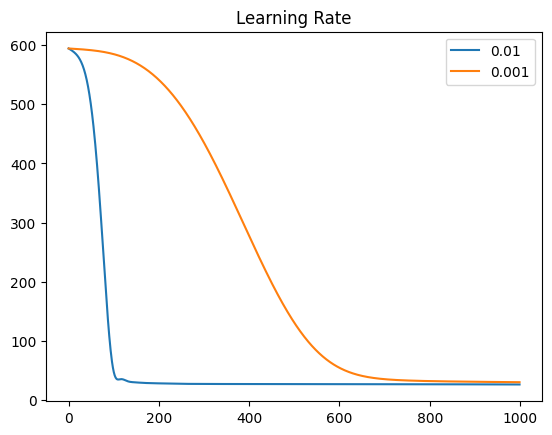

In [35]:
# ================= LEARNING RATE =================

_,l1=train(X_train,y_train,"adam",0.01)
_,l2=train(X_train,y_train,"adam",0.001)

plt.plot(l1,label="0.01")
plt.plot(l2,label="0.001")
plt.legend(); plt.title("Learning Rate"); plt.show()

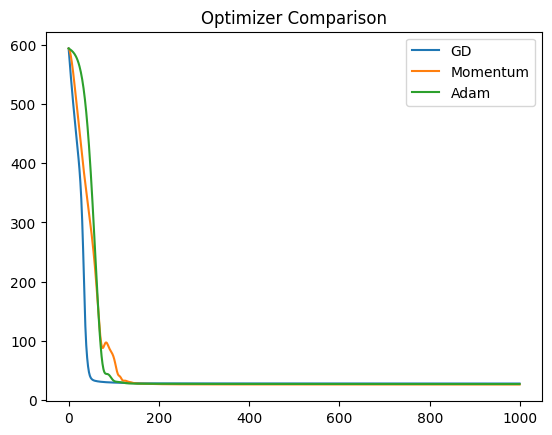

In [36]:
# ================= OPTIMIZERS =================

_,lg=train(X_train,y_train,"gd")
_,lm=train(X_train,y_train,"momentum")
_,la=train(X_train,y_train,"adam")

plt.plot(lg,label="GD")
plt.plot(lm,label="Momentum")
plt.plot(la,label="Adam")
plt.legend(); plt.title("Optimizer Comparison"); plt.show()


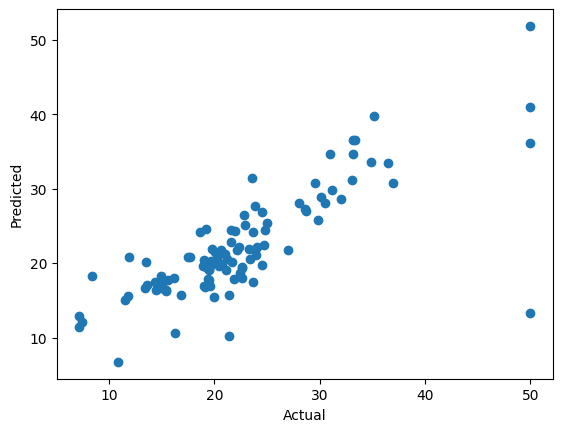

In [37]:
params,_=train(X_train,y_train,"adam")
yp,_=forward(X_test,params)
mse_base=mse(y_test,yp)

plt.scatter(y_test,yp)
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.show()

In [38]:
params_l2,_=train(X_train,y_train,"adam",l2=0.01)
yp2,_=forward(X_test,params_l2)
mse_l2=mse(y_test,yp2)


In [39]:
# ================= THIRD HIDDEN LAYER BONUS =================

def init3():
    return {
        "W1":np.random.randn(2,5)*0.01,"b1":np.zeros((1,5)),
        "W2":np.random.randn(5,3)*0.01,"b2":np.zeros((1,3)),
        "W3":np.random.randn(3,2)*0.01,"b3":np.zeros((1,2)),
        "W4":np.random.randn(2,1)*0.01,"b4":np.zeros((1,1))
    }

def forward3(X,p):
    A1=relu(X@p["W1"]+p["b1"])
    A2=relu(A1@p["W2"]+p["b2"])
    A3=relu(A2@p["W3"]+p["b3"])
    Z4=A3@p["W4"]+p["b4"]
    return Z4

p3=init3()
for i in range(1000):
    y3=forward3(X_train,p3)
    p3["W4"]-=0.01*np.mean((y3-y_train)*X_train[:,0:1])

yp3=forward3(X_test,p3)
mse_3=mse(y_test,yp3)

In [40]:
# ================= RESULTS =================

print("Base MSE:",mse_base)
print("With L2:",mse_l2)
print("3 Hidden Layers:",mse_3)

Base MSE: 27.690039173712766
With L2: 28.1613457279773
3 Hidden Layers: 583.7809098021606
